In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
import os, sys
from scipy.stats import norm, skewnorm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, make_scorer, log_loss, roc_auc_score, brier_score_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
proj_dir = 'C:/Users/ady05/Desktop/NU/DANA/NVQI/prob_learning_new/'
workspace = proj_dir + 'XgbDist/OtherModels/MC-nihss/'
util_dir = proj_dir + 'XgbDist/utils/'
data_dir = proj_dir + 'datasets/'
proc_dir = proj_dir + 'data processing/'

In [3]:
sys.path.insert(0, util_dir)
from data_proc import data_proc_nihss2
from plot_measures import plot_feature_importance

# Data Processing

In [4]:
df_data = pd.read_excel(proc_dir + 'data2.xlsx')
df_num = pd.read_excel(data_dir + 'vargroups_numeric_new.xlsx')
df_cat = pd.read_excel(data_dir + 'vargroups_categorical_new.xlsx')

groupname = 'group 24h'

In [5]:
X_data, y_data, num_names, cat_names = data_proc_nihss2(df_data, df_num, df_cat, groupname)
(X_data.shape, y_data.shape)

((2647, 80), (2647,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.8, random_state=1121218
)

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((2117, 80), (2117,), (530, 80), (530,))

# MC dropout model

In [7]:
tf.random.set_seed(42)

def build_mc_dropout_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1)  
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) 
    return model

input_shape = X_train.shape[1]
mc_dropout_model = build_mc_dropout_model(input_shape)
mc_dropout_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

n_samples = 100  
y_preds_mc = []

for _ in range(n_samples):
    y_pred = mc_dropout_model(X_test, training=True)  
    y_preds_mc.append(y_pred)

y_preds_mc = np.array(y_preds_mc)
y_mean_mc = y_preds_mc.mean(axis=0).ravel()  
y_std_mc = y_preds_mc.std(axis=0).ravel() 

mse_mc = mean_squared_error(y_test, y_mean_mc)
mae_mc = mean_absolute_error(y_test, y_mean_mc)

print(f"Monte Carlo Dropout Mean Squared Error (MSE): {mse_mc:.4f}")
print(f"Monte Carlo Dropout Mean Absolute Error (MAE): {mae_mc:.4f}")

Epoch 1/20
53/53 [==============================] - 1s 5ms/step - loss: 59.9538 - mae: 5.4922 - val_loss: 40.7749 - val_mae: 4.8416
Epoch 2/20
53/53 [==============================] - 0s 2ms/step - loss: 41.4954 - mae: 4.7841 - val_loss: 31.1363 - val_mae: 4.1511
Epoch 3/20
53/53 [==============================] - 0s 2ms/step - loss: 33.9031 - mae: 4.2759 - val_loss: 25.7654 - val_mae: 3.6840
Epoch 4/20
53/53 [==============================] - 0s 2ms/step - loss: 30.1149 - mae: 3.9511 - val_loss: 23.2590 - val_mae: 3.3310
Epoch 5/20
53/53 [==============================] - 0s 2ms/step - loss: 26.9978 - mae: 3.6901 - val_loss: 22.0448 - val_mae: 3.2232
Epoch 6/20
53/53 [==============================] - 0s 2ms/step - loss: 25.6875 - mae: 3.6068 - val_loss: 21.6191 - val_mae: 3.0733
Epoch 7/20
53/53 [==============================] - 0s 2ms/step - loss: 24.5824 - mae: 3.5153 - val_loss: 21.3110 - val_mae: 3.0337
Epoch 8/20
53/53 [==============================] - 0s 2ms/step - loss: 23.7

# Measures

In [8]:
def root_mean_squared_error(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))
def normal_nll(loc, scale, y_test):
    return -norm.logpdf(y_test.flatten(), loc=loc, scale=scale).mean()

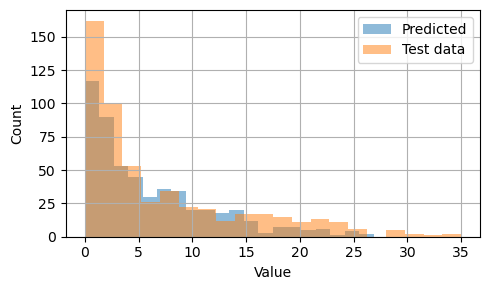

In [9]:
plt.figure(figsize=(5, 3))
plt.hist(y_mean_mc, bins=20, alpha=0.5, label='Predicted')
plt.hist(y_test,         bins=20, alpha=0.5, label='Test data')
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Count')    
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
def plot_residuals(y_true, y_pred, y_err):
    fig, ax = plt.subplots()
    ax.errorbar(
        y_true,
        y_true - y_pred,
        yerr=y_err,
        marker="o",
        linestyle="None",
        c="k",
        markersize=2.5,
        linewidth=0.5,
    )
    ax.axhline(0, c="k", linestyle="--")
    ax.set_xlabel("Actual data")
    ax.set_ylabel("Residuals: Actual - Predicted")
    plt.show()

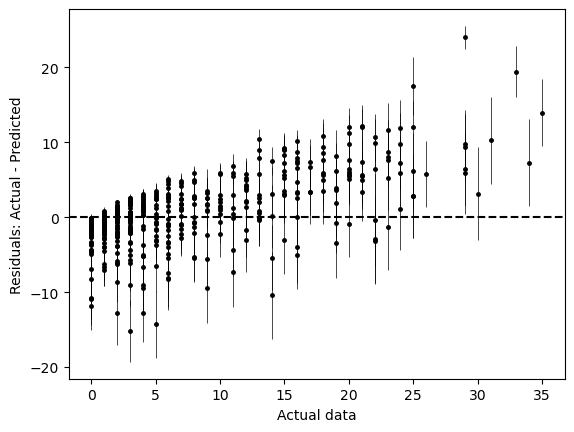

In [11]:
plot_residuals(y_test, y_mean_mc, y_std_mc)

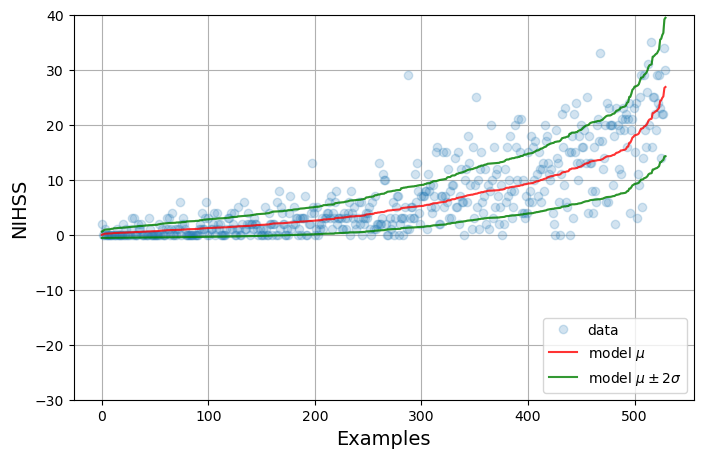

In [12]:
y_true = np.squeeze(y_test)
y_mean = np.squeeze(y_mean_mc)
y_sd = np.squeeze(y_std_mc)

fit_sd = np.poly1d(np.polyfit(x=y_mean, y=y_sd, deg=5))
y_sd_fit = fit_sd(y_mean)
order = np.argsort(y_mean)
y_lower = y_mean - 2*y_sd_fit
y_upper = y_mean + 2*y_sd_fit

plt.figure(figsize=(8, 5))
plt.plot(y_true[order], 'o', alpha=0.2, label='data')
plt.plot(y_mean[order], color='red', alpha=0.8, label='model $\mu$')
plt.plot(y_lower[order], color='green', alpha=0.15)
plt.plot(y_upper[order], color='green', alpha=0.15)
plt.plot(y_lower[order], color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
plt.plot(y_upper[order], color='green', alpha=0.8)
plt.xlabel('Examples', fontsize=14)
plt.ylabel('NIHSS', fontsize=14)
plt.ylim((-30, 40))
plt.legend(loc='lower right')
plt.grid()
plt.show()